# Data Pipeline: Pipeline of Temperatures and Wildfires

## 1. Import necessary libraries

___

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import numpy as np
import datetime as dt
import folium
from IPython import display
from ipywidgets import widgets, interact
from math import ceil

%matplotlib inline

## 2. Import necessary data

___

In [62]:
# extracting temperatures from the csv dataset
climate_country = pd.read_csv('data/climate_change/GlobalLandTemperaturesByCountry.csv')
temperatures = pd.DataFrame(climate_country)

# extracting data from wildfires from the sql dataset (this takes some time)
conn = sql.connect('data/us_wildfires/FPA_FOD_20170508.sqlite')
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
query = conn.execute("SELECT * From 'Fires'")
cols = [column[0] for column in query.description]
wildfire = pd.DataFrame.from_records(data = query.fetchall(), columns=cols)

## 3. Data wrangling

___

In [65]:
# let's take a look at those dataframes
print(wildfire.shape)
print(temperatures.shape)

(1880465, 39)
(577462, 4)


In [66]:
# exploring data from the temperatures dataset: data types
climate_country.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
Country                           object
dtype: object

In [30]:
# exploring data from the temperatures dataset: general outline
# dt is the date, expressed in 'yyyy-mm-dd' format. there is the daily av. temp. and uncertainty, and country.
# many values seem to be missing from the tem peratures, wich might be a problem only from early days.

climate_country.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [31]:
# printing the countries attribute, to search for the United States exact call

print(climate_country['Country'].nunique())
print(climate_country['Country'].unique())

array(['Åland', 'Afghanistan', 'Africa', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica',
       'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria',
       'Burkina Faso', 'Burma', 'Burundi', "Côte D'Ivoire", 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Comoros',
       'Congo (Democratic Republic Of The)', 'Congo', 'Costa Rica',
       'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic',
       'Denmark (Europe)', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecu

In [32]:
# extracting actual records from temperatures in the United States

climate_rec = climate_country.dropna(axis=0)
climate_us = climate_country[(climate_country['Country']=='United States')]

In [33]:
# exploring data from the wildfires dataset

wildfire.dtypes

OBJECTID                      int64  
FOD_ID                        int64  
FPA_ID                        object 
SOURCE_SYSTEM_TYPE            object 
SOURCE_SYSTEM                 object 
NWCG_REPORTING_AGENCY         object 
NWCG_REPORTING_UNIT_ID        object 
NWCG_REPORTING_UNIT_NAME      object 
SOURCE_REPORTING_UNIT         object 
SOURCE_REPORTING_UNIT_NAME    object 
LOCAL_FIRE_REPORT_ID          object 
LOCAL_INCIDENT_ID             object 
FIRE_CODE                     object 
FIRE_NAME                     object 
ICS_209_INCIDENT_NUMBER       object 
ICS_209_NAME                  object 
MTBS_ID                       object 
MTBS_FIRE_NAME                object 
COMPLEX_NAME                  object 
FIRE_YEAR                     int64  
DISCOVERY_DATE                float64
DISCOVERY_DOY                 int64  
DISCOVERY_TIME                object 
STAT_CAUSE_CODE               float64
STAT_CAUSE_DESCR              object 
CONT_DATE                     float64
CONT_DOY    

In [34]:
# selecting useful columns from the temperatures dataset
# might have columns with very low variability, and in so relevance, and columns with very high correlation.
# we can see from this that, what might interest us, is FIRE_YEAR, DISCOVERY_DOY, LATITUDE, LONGITUDE and OBJECTID

pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',-1)
pd.set_option('display.width',None)
wildfire.head(15)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@|\x01\x00\x00\x00\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@\xfe'
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@|\x01\x00\x00\x00T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@\xfe'
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,"b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@|\x01\x00\x00\x00\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@\xfe'"
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]\xc0\xe8T\x00\xc6\x92GC@\x94\xac\xa3\rt\xfa]\xc0\xe8T\x00\xc6\x92GC@|\x01\x00\x00\x00\x94\xac\xa3\rt\xfa]\xc0\xe8T\x00\xc6\x92GC@\xfe'
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\xc0\xe8T\x00\xc6\x92GC@@\xe3\xaa.\xb7\xfb]\xc0\xe8T\x00\xc6\x92GC@|\x01\x00\x00\x00@\xe3\xaa.\xb7\xfb]\xc0\xe8T\x00\xc6\x92GC@\xfe'
5,6,6,FS-1418849,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,54,8,None,HIDDEN,None,None,None,None,None,2004,2453186.5,182,1800,1.0,Lightning,2453187.5,183.0,1600,0.10,A,38.635278,-120.103611,5.0,USFS,CA,5,005,Amador,b'\x00\x01\xad\x10\x00\x00\xf0<~\x90\xa1\x06^\xc0\xe0|D\xc8PQC@\xf0<~\x90\xa1\x06^\xc0\xe0|D\xc8PQC@|\x01\x00\x00\x00\xf0<~\x90\xa1\x06^\xc0\xe0|D\xc8PQC@\xfe'
6,7,7,FS-1418851,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,58,9,None,FORK,None,None,None,None,None,2004,2453187.5,183,1800,1.0,Lightning,2453188.5,184.0,1400,0.10,A,38.688333,-120.153333,5.0,USFS,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00$o\x996\xd0\t^\xc0h\x8czN\x1bXC@$o\x996\xd0\t^\xc0h\x8czN\x1bXC@|\x01\x00\x00\x00$o\x996\xd0\t^\xc0h\x8czN\x1bXC@\xfe'
7,8,8,FS-1418854,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,3,02,BK5X,SLATE,None,None,None,None,None,2005,2453437.5,67,1300,5.0,Debris Burning,2453437.5,67.0,1600,0.80,B,40.968056,-122.433889,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00t)\xe8\xd5\xc4\x9b^\xc0\xa0t\x9d>\xe9{D@t)\xe8\xd5\xc4\x9b^\xc0\xa0t\x9d>\xe9{D@|\x01\x00\x00\x00t)\xe8\xd5\xc4\x9b^\xc0\xa0t\x9d>\xe9{D@\xfe'
8,9,9,FS-1418856,FED,FS-FIRESTAT,FS,USCASHF

In [35]:
"""let's see if there is any difference between OBJECT_ID and FOD_ID, and if there is a difference,
wich one should be chosen."""

wildfire['OBJECTID'].nunique()
wildfire['FOD_ID'].nunique()
len(wildfire['OBJECTID'])

# conclusion: they both have only unique values

1880465

In [36]:
# removing columns with low variance from wildfires dataset
# that resulted in an empty list

lo_var = []

for col in wildfire._get_numeric_data():
    mini = min(wildfire[col])
    ninety_perc = np.percentile(wildfire[col],90)
    if ninety_perc == mini:
        lo_var.append(col)

print(lo_var)

[]


In [37]:
# selecting columns with that would also be useful

firedata = wildfire[['OBJECTID','FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE','NWCG_REPORTING_UNIT_NAME','STAT_CAUSE_DESCR','FIRE_SIZE']]
firedata.head()

,OBJECTID,FIRE_YEAR,DISCOVERY_DOY,LATITUDE,LONGITUDE,NWCG_REPORTING_UNIT_NAME,STAT_CAUSE_DESCR,FIRE_SIZE
0,1,2005,33,40.036944,-121.005833,Plumas National Forest,Miscellaneous,0.10
1,2,2004,133,38.933056,-120.404444,Eldorado National Forest,Lightning,0.25
2,3,2004,152,38.984167,-120.735556,Eldorado National Forest,Debris Burning,0.10
3,4,2004,180,38.559167,-119.913333,Eldorado National Forest,Lightning,0.10
4,5,2004,180,38.559167,-119.933056,Eldorado National Forest,Lightning,0.10


In [38]:
# creating a column of equivalent month from the 'DISCOVERY_DOY' column in the firedata dataset

def dtm(days):
    """
    transforms days from a Julian year into the equivalent month
    
    only argument: number of days
    returns: month of equivalence as integer
    """
    monthd = [31,28,31,30,31,30,31,31,30,31,30,31]
    monthsum = []
    
    for i in range(len(monthd)):
        monthsum.append(sum(monthd[:i+1]))
    
    for i in monthsum:
        if days<=i:
            return int(monthsum.index(i)+1)

firedata['MONTH'] = firedata['DISCOVERY_DOY'].apply(dtm)
firedata = firedata.drop('DISCOVERY_DOY',axis=1)
firedata.head()

/home/nacholez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OBJECTID,FIRE_YEAR,LATITUDE,LONGITUDE,NWCG_REPORTING_UNIT_NAME,STAT_CAUSE_DESCR,FIRE_SIZE,MONTH
0,1,2005,40.036944,-121.005833,Plumas National Forest,Miscellaneous,0.10,2.0
1,2,2004,38.933056,-120.404444,Eldorado National Forest,Lightning,0.25,5.0
2,3,2004,38.984167,-120.735556,Eldorado National Forest,Debris Burning,0.10,6.0
3,4,2004,38.559167,-119.913333,Eldorado National Forest,Lightning,0.10,6.0
4,5,2004,38.559167,-119.933056,Eldorado National Forest,Lightning,0.10,6.0


In [39]:
# cleaning and setting values from the month column in firedata

firedata = firedata.replace([np.inf,-np.inf],np.nan) # dropping infinite values
firedata = firedata.dropna(axis=0)
firedata['MONTH'] = firedata['MONTH'].astype('int')
firedata.dtypes

OBJECTID                    int64  
FIRE_YEAR                   int64  
LATITUDE                    float64
LONGITUDE                   float64
NWCG_REPORTING_UNIT_NAME    object 
STAT_CAUSE_DESCR            object 
FIRE_SIZE                   float64
MONTH                       int64  
dtype: object

In [40]:
# creating a column of month and year in the climate_us dataset

climate_us['Year'] = pd.DatetimeIndex(climate_us['dt']).year
climate_us['Month'] = pd.DatetimeIndex(climate_us['dt']).month
climate_us.head()

/home/nacholez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nacholez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Year,Month
554880,1768-09-01,15.420,2.880,United States,1768,9
554881,1768-10-01,8.162,3.386,United States,1768,10
554882,1768-11-01,1.591,3.783,United States,1768,11
554883,1768-12-01,-2.882,4.979,United States,1768,12
554884,1769-01-01,-3.952,4.856,United States,1769,1


In [41]:
# dividing the temperatures into two datasets: the early values, and the ones equivalent to the wildfires dataset

climate_rl = climate_us.loc[(climate_us['Year'] > climate_us['Year'].min()) & (climate_us['Year'] < climate_us['Year'].min()+12)]
climate_eq = climate_us.loc[(climate_us['Year'] >= firedata['FIRE_YEAR'].min()) & (climate_us['Year'] <= firedata['FIRE_YEAR'].max())]

In [42]:
# creating a merging key for the main datasets

climate_eq['Date'] = climate_eq.apply(lambda row: dt.datetime(row['Year'],row['Month'],1), axis=1)
firedata['Date'] = firedata.apply(lambda row: dt.datetime(int(row['FIRE_YEAR']),int(row['MONTH']),1), axis=1)

/home/nacholez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
# merging the datasets through the date key

temp_fire = pd.merge(firedata,climate_eq,on='Date',how='inner')
temp_fire.head()

,OBJECTID,FIRE_YEAR,LATITUDE,LONGITUDE,NWCG_REPORTING_UNIT_NAME,STAT_CAUSE_DESCR,FIRE_SIZE,MONTH,Date,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Year,Month
0,1,2005,40.036944,-121.005833,Plumas National Forest,Miscellaneous,0.1,2,2005-02-01,2005-02-01,0.408,0.16,United States,2005,2
1,32,2005,43.995556,-121.414167,Deschutes National Forest,Campfire,0.1,2,2005-02-01,2005-02-01,0.408,0.16,United States,2005,2
2,39,2005,35.931667,-81.716667,National Forests in North Carolina,Arson,0.1,2,2005-02-01,2005-02-01,0.408,0.16,United States,2005,2
3,40,2005,36.001667,-81.590000,National Forests in North Carolina,Debris Burning,125.0,2,2005-02-01,2005-02-01,0.408,0.16,United States,2005,2
4,49,2005,43.725278,-121.574167,Deschutes National Forest,Campfire,0.1,2,2005-02-01,2005-02-01,0.408,0.16,United States,2005,2


In [47]:
# removing unnecessary columns

temp_fire = temp_fire.drop(['OBJECTID','FIRE_YEAR','MONTH','Country','dt'],axis=1)
temp_fire.rename(columns={'AverageTemperature':'current_av_temperature','AverageTemperatureUncertainty':'current_uncertainty'},inplace=True)
temp_fire.head()

,LATITUDE,LONGITUDE,NWCG_REPORTING_UNIT_NAME,STAT_CAUSE_DESCR,FIRE_SIZE,Date,current_av_temperature,current_uncertainty,Year,Month
0,40.036944,-121.005833,Plumas National Forest,Miscellaneous,0.1,2005-02-01,0.408,0.16,2005,2
1,43.995556,-121.414167,Deschutes National Forest,Campfire,0.1,2005-02-01,0.408,0.16,2005,2
2,35.931667,-81.716667,National Forests in North Carolina,Arson,0.1,2005-02-01,0.408,0.16,2005,2
3,36.001667,-81.590000,National Forests in North Carolina,Debris Burning,125.0,2005-02-01,0.408,0.16,2005,2
4,43.725278,-121.574167,Deschutes National Forest,Campfire,0.1,2005-02-01,0.408,0.16,2005,2


In [48]:
# create a monthly baseline of temperature changes in the USA from the 11 first recorded years

early_av = climate_rl.groupby('Month').mean().reset_index()
early_av.set_index([pd.Index([1,2,3,4,5,6,7,8,9,10,11,12])])
early_av['Month'] = [1,2,3,4,5,6,7,8,9,10,11,12]
early_av = early_av.drop(['Year'],axis=1)
early_av.rename(columns={'AverageTemperature':'early_av_temperature','AverageTemperatureUncertainty':'early_uncertainty'},inplace=True)
early_av

,Month,early_av_temperature,early_uncertainty
0,1,-3.404500,3.90150
1,2,-0.439400,3.78680
2,3,2.876600,3.01600
3,4,7.399000,2.42750
4,5,14.437500,3.04400
5,6,18.554200,2.78420
6,7,20.952500,2.31450
7,8,20.626250,2.49475
8,9,15.116667,2.45700
9,10,8.619200,2.92100


In [49]:
# merge the new column, making relative calculations possible

temp_fire = pd.merge(temp_fire,early_av,on='Month')

In [50]:
# creating one last column: 'rel_tem', as a measure of the temperature increase, relative to the baseline

temp_fire['rel_temperature'] = temp_fire['current_av_temperature']-temp_fire['early_av_temperature']
temp_fire.head()

,LATITUDE,LONGITUDE,NWCG_REPORTING_UNIT_NAME,STAT_CAUSE_DESCR,FIRE_SIZE,Date,current_av_temperature,current_uncertainty,Year,Month,early_av_temperature,early_uncertainty,rel_temperature
0,40.036944,-121.005833,Plumas National Forest,Miscellaneous,0.1,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474
1,43.995556,-121.414167,Deschutes National Forest,Campfire,0.1,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474
2,35.931667,-81.716667,National Forests in North Carolina,Arson,0.1,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474
3,36.001667,-81.590000,National Forests in North Carolina,Debris Burning,125.0,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474
4,43.725278,-121.574167,Deschutes National Forest,Campfire,0.1,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474


In [51]:
# saving final dataset in a csv document

temp_fire.to_csv('output/temp_fire.csv')

## 4. Data Analysis

___

In [4]:
# reading exported csv, in case the notebook was closed

temp_fire = pd.read_csv('output/temp_fire.csv')
temp_fire.drop('Unnamed: 0',axis=1,inplace=True)
temp_fire.sort_values(by=['Year','Month'],inplace=True)

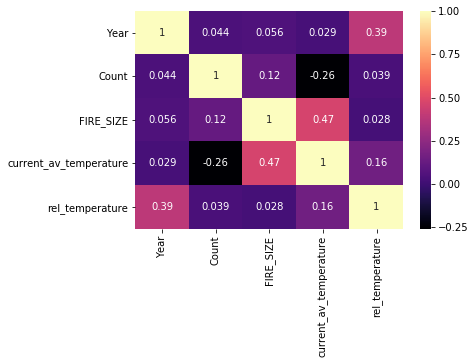

In [5]:
# correlation between count of monthly fires and fire sizes, and temperatures 
# (baseline and present)

new_df = pd.DataFrame
new_df = temp_fire[['Year','FIRE_SIZE','STAT_CAUSE_DESCR']].groupby(['Year','STAT_CAUSE_DESCR']).count().reset_index()
new_df.rename({'FIRE_SIZE':'Count'},axis=1,inplace=True)
new_df = new_df.merge(temp_fire[['Year','FIRE_SIZE','current_av_temperature','rel_temperature','STAT_CAUSE_DESCR']].groupby(['Year','STAT_CAUSE_DESCR']).mean().reset_index(),on=['Year','STAT_CAUSE_DESCR'])
sns.heatmap(new_df.corr(),cmap='magma',annot=True);

# weak correlation between fire sizes and number of fires
# average negative correlation between number of fires and average temperatures
# strongest correlation between temperature increase and year

In [56]:
# taking a look into the created dataframe

new_df.head()

,Year,STAT_CAUSE_DESCR,Count,FIRE_SIZE,current_av_temperature,rel_temperature
0,1992,Arson,11153,23.962908,8.036319,0.709693
1,1992,Campfire,2570,10.479276,14.241684,0.040815
2,1992,Children,2913,17.470997,10.721066,0.441100
3,1992,Debris Burning,12726,12.116623,7.714247,0.770135
4,1992,Equipment Use,5630,24.183606,12.512860,0.194698


In [7]:
# let's take a look at our data


print('the number of national wildfire reporting groups is',temp_fire['NWCG_REPORTING_UNIT_NAME'].nunique())
print('the maximum reported latitude is',temp_fire['LATITUDE'].max())
print('the minimum reported latitude is',temp_fire['LATITUDE'].min())
print('the maximum reported longitude is',temp_fire['LONGITUDE'].max())
print('the minimum reported longitude is',temp_fire['LONGITUDE'].min())
print('the maximum reported fire size (in acres) was',temp_fire['FIRE_SIZE'].max())
print('the minimum reported fire size (in acres) was',temp_fire['FIRE_SIZE'].min())
print('the average reported fire size (in acres) was',temp_fire['FIRE_SIZE'].mean())
print('the maximum monthly national average temperature was',temp_fire['current_av_temperature'].max())
print('the minimum monthly national average temperature was',temp_fire['current_av_temperature'].min())
print('the maximum monthly national average temperature increase was',temp_fire['rel_temperature'].max())
print('the maximum monthly national average temperature decrease was',temp_fire['rel_temperature'].min())
print('the average monthly national average temperature variation from standpoint was',temp_fire['rel_temperature'].mean())
print('the number of reported fire causes is',temp_fire['STAT_CAUSE_DESCR'].nunique())
print('earliest data',temp_fire['Date'].min())
print('latest data',temp_fire['Date'].max())
print('those fire causes are',temp_fire['STAT_CAUSE_DESCR'].unique())

the number of national wildfire reporting groups is 1575
the maximum reported latitude is 70.1381
the minimum reported latitude is 17.93972222
the maximum reported longitude is -65.25694444
the minimum reported longitude is -178.8026
the maximum reported fire size (in acres) was 606945.0
the minimum reported fire size (in acres) was 9e-05
the average reported fire size (in acres) was 72.94718615553683
the maximum monthly national average temperature was 23.00800000000001
the minimum monthly national average temperature was -4.316000000000002
the maximum monthly national average temperature increase was 3.267333333333335
the maximum monthly national average temperature decrease was -2.1826
the average monthly national average temperature variation from standpoint was 0.8734214292869618
the number of reported fire causes is 13
earliest data 1992-01-01
latest data 2013-09-01
those fire causes are ['Smoking' 'Miscellaneous' 'Arson' 'Campfire' 'Debris Burning' 'Lightning'
 'Equipment Use' '

In [340]:
# which were the biggest wildfires?

temp_fire[['NWCG_REPORTING_UNIT_NAME','STAT_CAUSE_DESCR','FIRE_SIZE','Date','current_av_temperature']].sort_values('FIRE_SIZE').tail(10)

,NWCG_REPORTING_UNIT_NAME,STAT_CAUSE_DESCR,FIRE_SIZE,Date,current_av_temperature
1359317,Winnemucca District Office,Lightning,461047.0,2012-08-01,21.422
289793,Alaska State Office,Lightning,463994.0,2004-06-01,19.228
683381,Lake Meredith National Recreation Area,Missing/Undefined,479549.0,2006-03-01,2.794
442346,Alaska State Office,Lightning,483280.0,2004-07-01,21.663
460041,Rogue River-Siskiyou National Forest,Lightning,499945.0,2002-07-01,22.675
332574,Alaska State Office,Lightning,517078.0,2009-06-01,18.962
289736,Alaska State Office,Lightning,537627.0,2004-06-01,19.228
267893,Apache-Sitgreaves National Forest,Campfire,538049.0,2011-05-01,13.759
642682,Vale District,Lightning,558198.3,2012-07-01,23.008
368511,Alaska State Office,Lightning,606945.0,1997-06-01,19.042


In [75]:
temp_fire.STAT_CAUSE_DESCR

0              Miscellaneous
1                   Campfire
2                      Arson
3             Debris Burning
4                   Campfire
                 ...        
1729609    Missing/Undefined
1729610    Missing/Undefined
1729611              Smoking
1729612              Smoking
1729613    Missing/Undefined
Name: STAT_CAUSE_DESCR, Length: 1729614, dtype: object

In [106]:
new_df.tail()

,Year,STAT_CAUSE_DESCR,Count,FIRE_SIZE,current_av_temperature,rel_temperature
281,2013,Missing/Undefined,3766,52.843882,14.325303,0.648449
282,2013,Powerline,588,12.116015,11.491197,0.391026
283,2013,Railroad,393,8.744224,12.536481,0.185190
284,2013,Smoking,1195,2.211096,11.800954,0.339751
285,2013,Structure,194,3.824227,9.702129,0.222954


In [45]:
# correlation between fire sizes and altitude
# for a spacial ranking, I'ss opt for a the Spearman method

temp_fire[['LATITUDE','LONGITUDE','FIRE_SIZE']].corr(method='spearman')

# there seems to be a sensible but weak negative correlation with latitude, and almost none with longitude

,LATITUDE,LONGITUDE,FIRE_SIZE
LATITUDE,1.000000,-0.293453,-0.264935
LONGITUDE,-0.293453,1.000000,0.149849
FIRE_SIZE,-0.264935,0.149849,1.000000


## 5. Printing of graphs


___

In [188]:
# 

temp_fire.head()

,Unnamed: 0,LATITUDE,LONGITUDE,NWCG_REPORTING_UNIT_NAME,STAT_CAUSE_DESCR,FIRE_SIZE,Date,current_av_temperature,current_uncertainty,Year,Month,early_av_temperature,early_uncertainty,rel_temperature
0,0,40.036944,-121.005833,Plumas National Forest,Miscellaneous,0.1,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474
1,1,43.995556,-121.414167,Deschutes National Forest,Campfire,0.1,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474
2,2,35.931667,-81.716667,National Forests in North Carolina,Arson,0.1,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474
3,3,36.001667,-81.590000,National Forests in North Carolina,Debris Burning,125.0,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474
4,4,43.725278,-121.574167,Deschutes National Forest,Campfire,0.1,2005-02-01,0.408,0.16,2005,2,-0.4394,3.7868,0.8474


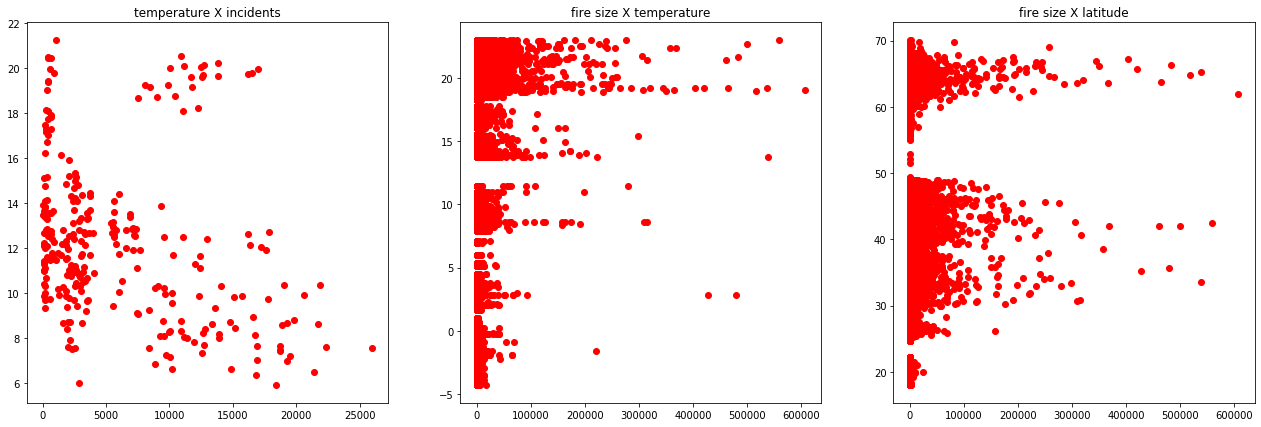

In [11]:
# THIS scatterplot between average teperatures and number of monthly fires

fig, axs = plt.subplots(1,3,figsize=(22,7),sharey=False)

axs[0].scatter('Count','current_av_temperature', data=new_df,c='r')
axs[1].scatter('FIRE_SIZE','current_av_temperature', data=temp_fire,c='r')
axs[2].scatter('FIRE_SIZE','LATITUDE', data=temp_fire,c='r')
axs[0].set_title('temperature X incidents')
axs[1].set_title('fire size X temperature')
axs[2].set_title('fire size X latitude');

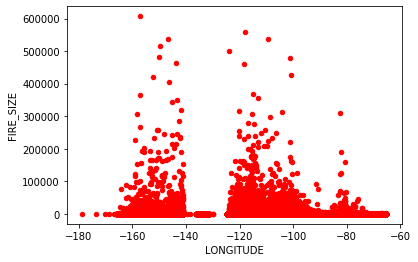

In [58]:
# scatterplot of fire incidents by fire size and latitude

temp_fire.plot.scatter('LONGITUDE','FIRE_SIZE',c='r');

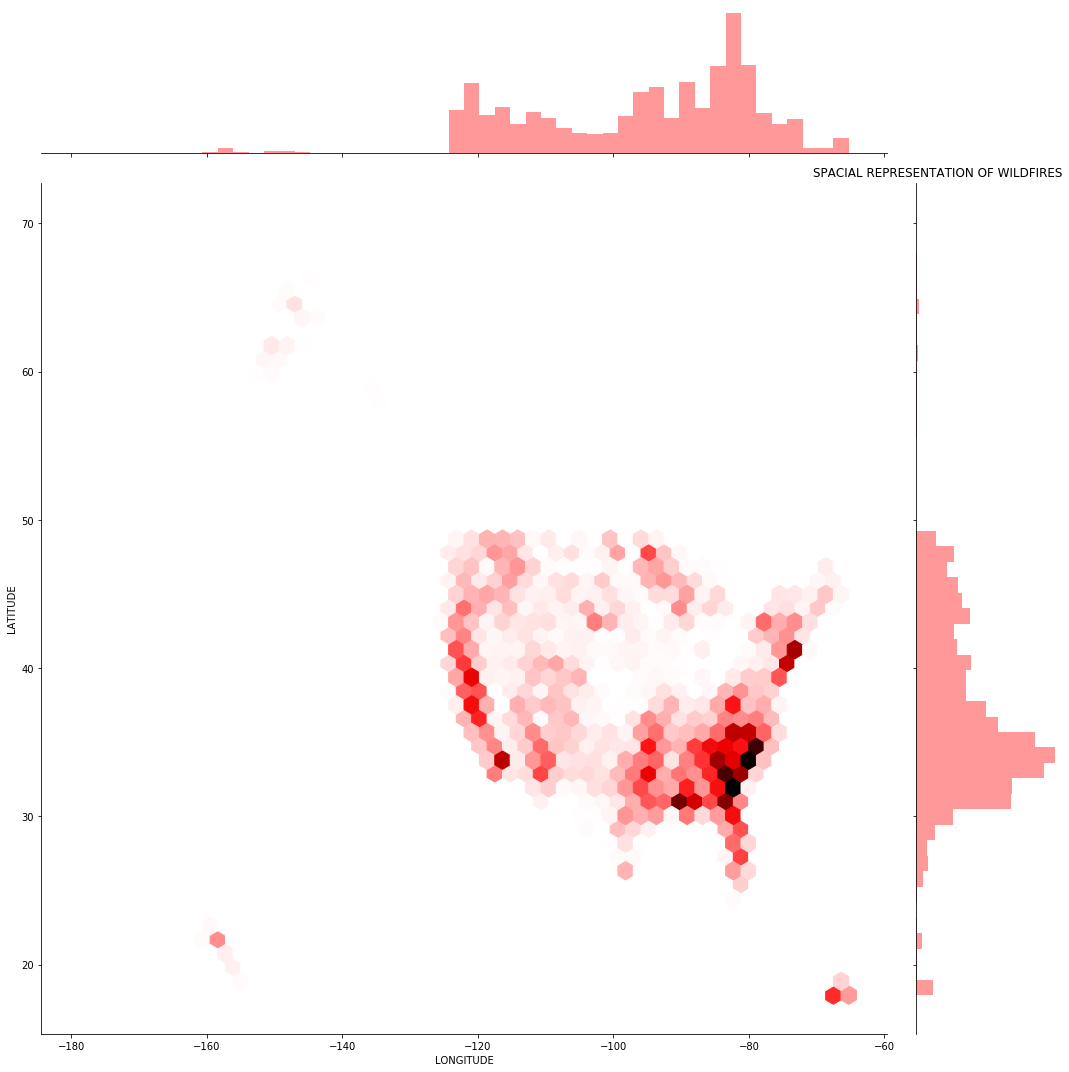

In [28]:
# plot those now as a sns.jointplot

sns.jointplot(x='LONGITUDE',
              y='LATITUDE',
              data=temp_fire,
              kind='hex',
              color='r',
              height=15)
plt.title('SPACIAL REPRESENTATION OF WILDFIRES');

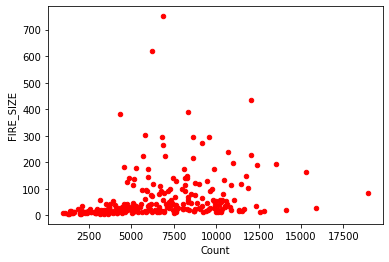

In [165]:
# scatterplot between number of fires and fire sizes


new_df.plot.scatter('Count','FIRE_SIZE',c='r');

In [6]:
# defining function to call 1 in 1000 largest fire incidents into map

def plotmonth(month,year):
    data = temp_fire[temp_fire.Year == year]
    data = data[data.Month == month]
    data = data.sort_values('FIRE_SIZE').tail(ceil(len(data)/1000))
    usmap = folium.Map(location=[50,-140],zoom_start=3)
    
    for fire in data.itertuples():
        folium.Marker(location=[fire.LATITUDE,fire.LONGITUDE],
                  popup='Cause: <strong>{}</strong>'.format(fire.STAT_CAUSE_DESCR),
                  icon=folium.Icon(icon='fire',color='red'),
                  tooltip=fire.NWCG_REPORTING_UNIT_NAME).add_to(usmap)
        
    return usmap

In [7]:
# map with fires along time, described by cause and reporting unit

interact(plotmonth,
         year=widgets.IntSlider(description='Year',
                                        min=temp_fire['Year'].min(),
                                        max=temp_fire['Year'].max(),
                                        step=1,
                                        value=temp_fire['Year'].min()),
         month=widgets.IntSlider(description='Month',
                                        min=temp_fire['Month'].min(),
                                        max=temp_fire['Month'].max(),
                                        step=1,
                                        value=temp_fire['Month'].min()));

interactive(children=(IntSlider(value=1, description='Month', max=12, min=1), IntSlider(value=1992, descriptio…

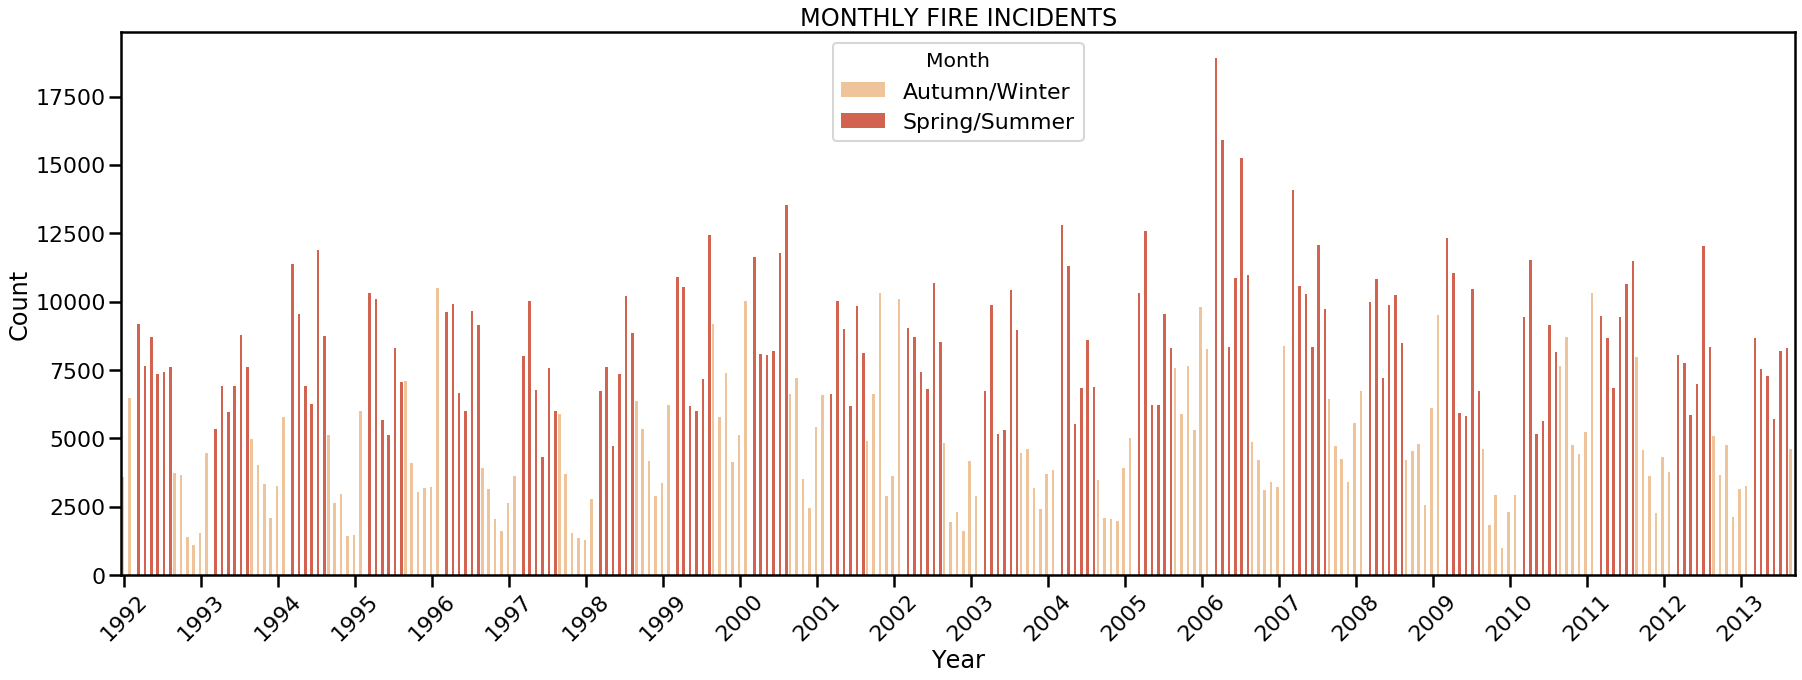

In [15]:
# temperatures in time with relative temperatures, along fire counts (bars)

plt.figure(figsize=(30,10))
sns.set_context('poster')
colors = temp_fire.Month.map(lambda x: "Spring/Summer" if x in list(range(3,9)) else "Autumn/Winter")
sns.countplot(x='Date',
              data=temp_fire,
              hue=colors,
              palette='OrRd',
              ).set_title('MONTHLY FIRE INCIDENTS')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(12*np.arange(len(temp_fire.Year.unique())),tuple(temp_fire.Year.unique()), rotation=45);

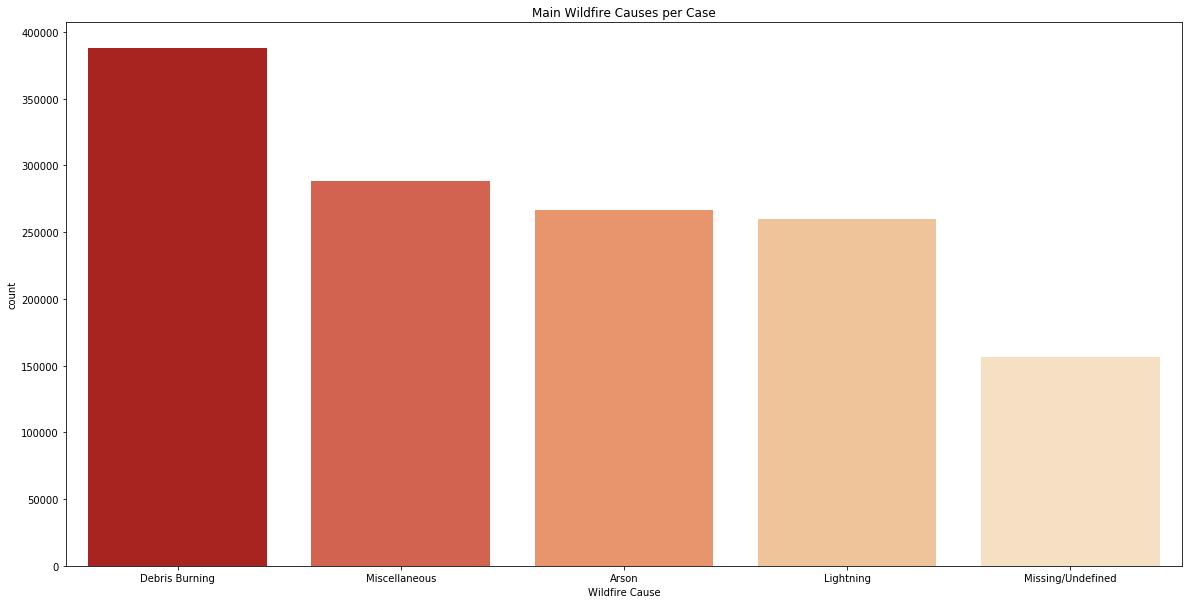

In [11]:
# main causes of fire incidents

plt.figure(figsize=(20,10))
sns.countplot(x='STAT_CAUSE_DESCR',
              data=temp_fire,
              palette='OrRd_r',
              order=temp_fire['STAT_CAUSE_DESCR'].value_counts().head(5).index).set_title('Main Wildfire Causes per Case')
plt.xlabel('Wildfire Cause');

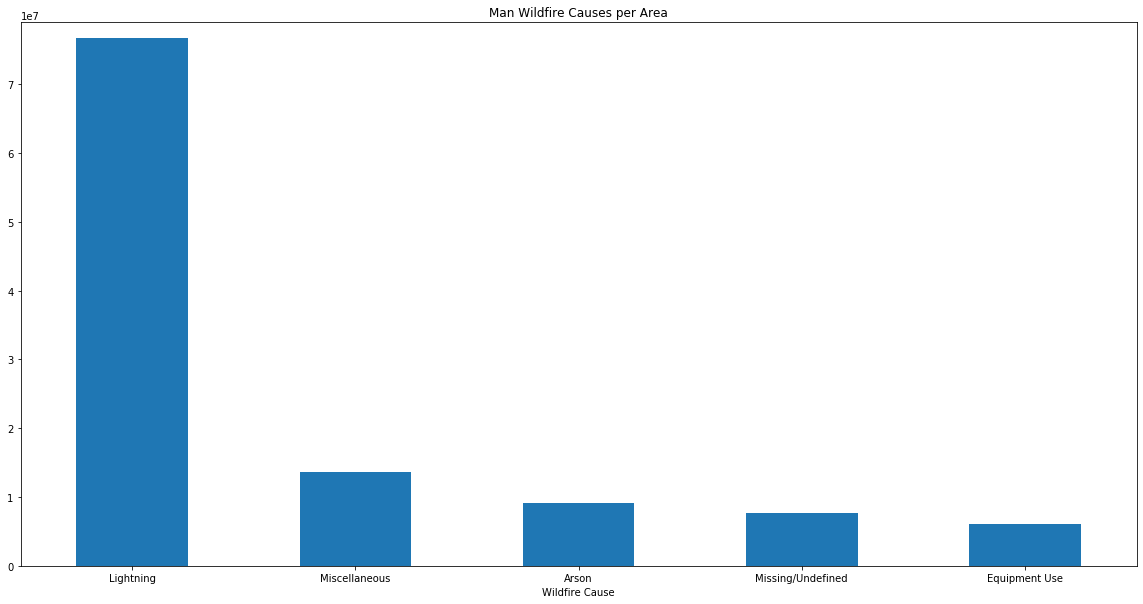

In [13]:
# main causes of fires by size

plt.figure(figsize=(20,10))
temp_fire.groupby('STAT_CAUSE_DESCR').FIRE_SIZE.sum().sort_values(ascending=False).head().plot(kind='bar').set_title('Man Wildfire Causes per Area')
plt.xlabel('Wildfire Cause')
plt.ylim([0,79000000])
plt.xticks(rotation=0);

In [8]:
# evolution in time of the fire cases by cause

def plotyear(year):
    data = new_df[new_df['Year']==year]
    size = data.Count
    colors = data.STAT_CAUSE_DESCR.map({'Miscellaneous':'silver', 
                                        'Campfire':'palegreen', 
                                        'Arson':'coral', 
                                        'Debris Burning':'gray',
                                        'Equipment Use':'palegreen', 
                                        'Smoking':'palegreen', 
                                        'Railroad':'palegreen', 
                                        'Children':'palegreen', 
                                        'Structure':'palegreen',
                                        'Fireworks':'palegreen', 
                                        'Lightning':'cyan', 
                                        'Missing/Undefined':'silver', 
                                        'Powerline':'palegreen'})
    data.plot.scatter('current_av_temperature',
                      'FIRE_SIZE',
                     s=size,
                     c=colors,
                     linewidth=1,
                     edgecolors='k',
                     figsize=(20,10));
    
    plt.xlabel('Average Temperature')
    plt.ylabel('Size of Fire (Acres)')
    plt.axis(xmin=-5,xmax=24,ymin=0,ymax=700)

In [9]:
# plotting widget of that last function

interact(plotyear,
         year=widgets.IntSlider(description='Year',
                                        min=new_df['Year'].min(),
                                        max=new_df['Year'].max(),
                                        step=1,
                                        value=new_df['Year'].min()));

# set labels and legends

interactive(children=(IntSlider(value=1992, description='Year', max=2013, min=1992), Output()), _dom_classes=(…

In [49]:
# all reported causes of fire incidents

temp_fire['STAT_CAUSE_DESCR'].unique()

array(['Miscellaneous', 'Campfire', 'Arson', 'Debris Burning',
       'Equipment Use', 'Smoking', 'Railroad', 'Children', 'Structure',
       'Fireworks', 'Lightning', 'Missing/Undefined', 'Powerline'],
      dtype=object)

In [10]:
# shape of the final file.a final look.

temp_fire.shape

(1729614, 13)